In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer, classification_report, confusion_matrix, roc_curve, auc
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from wordcloud import WordCloud, STOPWORDS
from imblearn.over_sampling import SMOTE
import seaborn as sns

In [2]:
data = pd.read_csv("Metadata - Labeled (1).csv")
data.head()

,State,Locality,Trace,Title,Filename,URL,Collection Date,Category,Keywords,Ancestor_keywords,Good,Cleaned Text
0,California,Los Angeles,Los Angeles Overview > Los Angeles Charter and...,Sec. 10.5.4. Authority of the General Manager ...,Los_Angeles-Sec._10.5.4._Authority_of_the_Gene...,https://codelibrary.amlegal.com/codes/los_ange...,28-Mar-23,Residential Lease & Rental,lease,NaN,False,Sec 10 5 4 Authority of the General Manager of...
1,California,Los Angeles,Los Angeles Overview > Los Angeles Charter and...,Sec. 10.51. Purpose,Los_Angeles-Sec._10.51._Purpose-Los_Angeles_Ov...,https://codelibrary.amlegal.com/codes/los_ange...,28-Mar-23,Residential Lease & Rental,NaN,housing,False,Sec 10 51 Purpose In November 2016 the voters ...
2,California,Los Angeles,Los Angeles Overview > Los Angeles Charter and...,Sec. 10.51.1. Definitions,Los_Angeles-Sec._10.51.1._Definitions-Los_Ange...,https://codelibrary.amlegal.com/codes/los_ange...,28-Mar-23,Residential Lease & Rental,NaN,housing,False,Sec 10 51 1 Definitions The following definiti...
3,California,Los Angeles,Los Angeles Overview > Los Angeles Charter and...,Sec. 10.51.10. Coexistence with Other Availabl...,Los_Angeles-Sec._10.51.10._Coexistence_with_Ot...,https://codelibrary.amlegal.com/codes/los_ange...,28-Mar-23,Residential Lease & Rental,NaN,housing,False,Sec 10 51 10 Coexistence with Other Available ...
4,California,Los Angeles,Los Angeles Overview > Los Angeles Charter and...,Sec. 10.51.11. Severability,Los_Angeles-Sec._10.51.11._Severability-Los_An...,https://codelibrary.amlegal.com/codes/los_ange...,28-Mar-23,Residential Lease & Rental,NaN,housing,False,Sec 10 51 11 Severability If a court of compet...


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 757 entries, 0 to 756
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   State              757 non-null    object
 1   Locality           757 non-null    object
 2   Trace              757 non-null    object
 3   Title              757 non-null    object
 4   Filename           757 non-null    object
 5   URL                757 non-null    object
 6   Collection Date    757 non-null    object
 7   Category           757 non-null    object
 8   Keywords           264 non-null    object
 9   Ancestor_keywords  579 non-null    object
 10  Good               757 non-null    bool  
 11  Cleaned Text       757 non-null    object
dtypes: bool(1), object(11)
memory usage: 65.9+ KB


In [4]:
data["Good"].value_counts()[True]

106

In [5]:
data["Good"].value_counts()[False]

651

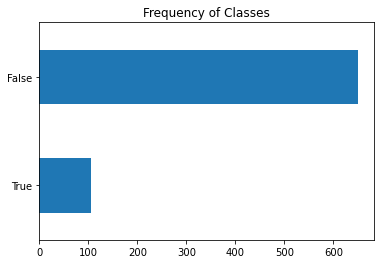

In [6]:
data["Good"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

In [7]:
def preprocess_text(text):
    # Replace the "Â§" symbol with an empty string
    text = text.replace('Â§', '')

    # Convert text to lowercase
    text = text.lower()

    # Remove special characters, digits, and punctuation
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
    
    # Remove leading and trailing whitespaces
    text = text.strip()
    
    # Tokenize the text
    words = nltk.word_tokenize(text)

    # Remove stopwords and useless words
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    
    # Join the words back into a single string
    text = ' '.join(words)

    return text

In [8]:
trace_column = data['Trace']
title_column = data['Title']
text_column = data['Cleaned Text']

In [9]:
trace_column = trace_column.apply(preprocess_text)
title_column = title_column.apply(preprocess_text)
text_column = text_column.apply(preprocess_text)

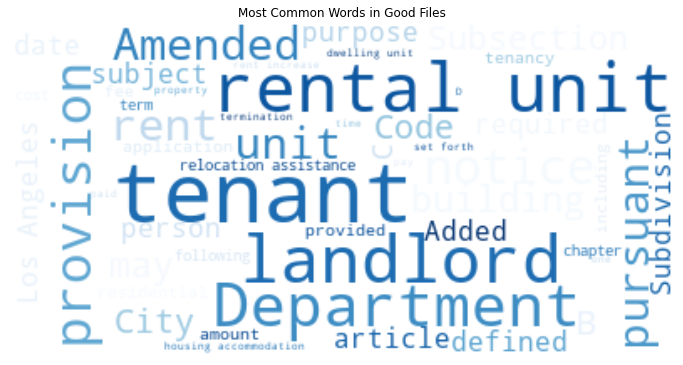

In [10]:
good_true_text = " ".join(data[data['Good'] == True]['Cleaned Text'])
stopwords = set(STOPWORDS)
stopwords.update(['Section', 'Ord', 'Eff'])
wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="white", 
                      colormap='Blues_r', stopwords=stopwords).generate(good_true_text)
plt.figure(figsize = (12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Words in Good Files")
plt.show()

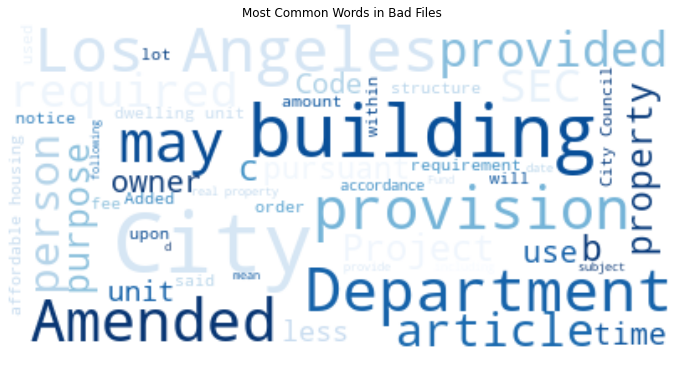

In [11]:
good_false_text = " ".join(data[data['Good'] == False]['Cleaned Text'])
stopwords = set(STOPWORDS)
stopwords.update(['Section', 'Ord', 'Eff'])
wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="white", 
                      colormap='Blues_r', stopwords=stopwords).generate(good_false_text)
plt.figure(figsize = (12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Words in Bad Files")
plt.show()

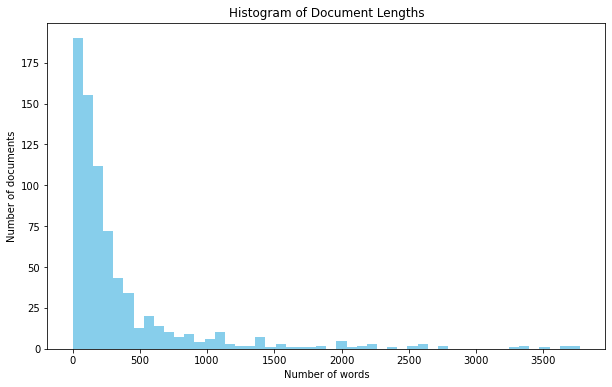

In [12]:
doc_lengths = [len(text.split()) for text in data['Cleaned Text']]
plt.figure(figsize=(10, 6))
plt.hist(doc_lengths, bins=50, range=(0, np.percentile(doc_lengths, 99)), color='skyblue')
plt.xlabel('Number of words')
plt.ylabel('Number of documents')
plt.title('Histogram of Document Lengths')
plt.show()

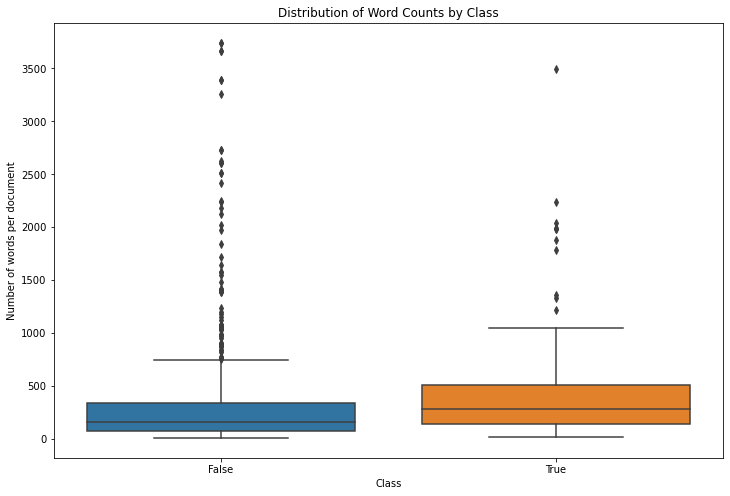

In [13]:
# Generate box plot of the number of words per class
data['Word Count'] = doc_lengths
plt.figure(figsize = (12, 8))
sns.boxplot(x='Good', y='Word Count', data=data[data['Word Count'] < data['Word Count'].quantile(0.99)])
plt.xlabel('Class')
plt.ylabel('Number of words per document')
plt.title('Distribution of Word Counts by Class')
plt.show()

In [14]:
vectorizer_trace = TfidfVectorizer()
vectorizer_title = TfidfVectorizer()
vectorizer_text = TfidfVectorizer()

trace_features = vectorizer_trace.fit_transform(trace_column)
title_features = vectorizer_title.fit_transform(title_column)
text_features = vectorizer_text.fit_transform(text_column)

In [15]:
combined_features = hstack([trace_features, title_features, text_features])

In [16]:
encoder = LabelEncoder()
relevance_encoded = encoder.fit_transform(data['Good'])

In [17]:
X_train, X_test, y_train, y_test = train_test_split(combined_features, 
                                                    relevance_encoded, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify = relevance_encoded)

In [18]:
# Define the hyperparameter grid to search over for Logistic Regression
param_grid_lr = {'C': [0.01, 0.1, 1, 10, 100],
              'penalty': ['l2'],
              'max_iter': [100, 500, 10000]}

# Define the hyperparameter grid to search over for Random Forest classifier
param_grid_rf = {'n_estimators': [50, 100, 200],
                 'max_depth': [5, 10, 20, None],
                 'min_samples_split': [2, 5, 10]}

# Define the hyperparameter grid to search over for XGBClassifier
param_grid_xgb = {'learning_rate': [0.1, 0.01],
                  'max_depth': [3, 5, 7],
                  'n_estimators': [50, 100, 200]}

In [19]:
# Define the models to try
models = {
    'Logistic Regression' : LogisticRegression(),
    'Random Forest Classifier' : RandomForestClassifier(),
    'XGBClassifier' : XGBClassifier()
}

In [20]:
scorer = make_scorer(f1_score, pos_label=True)

Logistic Regression
Best hyperparameters: {'C': 100, 'max_iter': 100, 'penalty': 'l2'}
[0.         0.         0.         0.02222222 0.02222222 0.02222222
 0.7817695  0.7817695  0.7817695  0.84493891 0.84493891 0.84493891
 0.85477761 0.85477761 0.85477761]


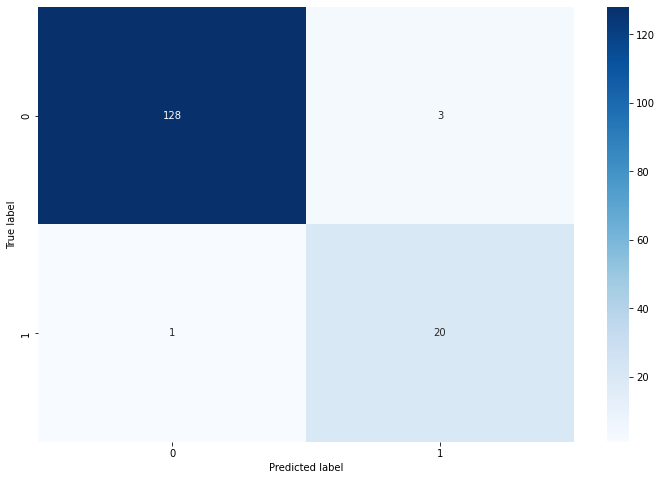

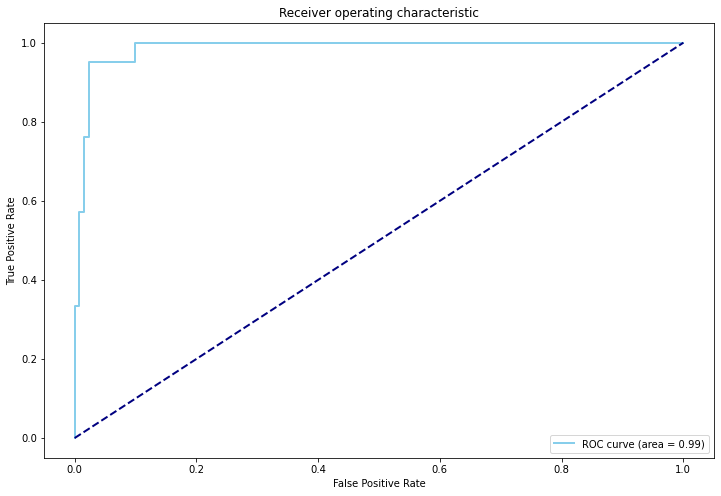

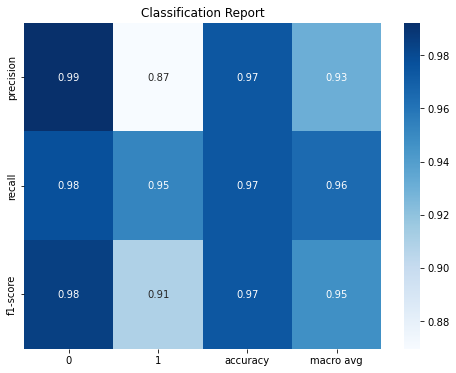

Accuracy: 0.97
Precision: 0.87
Recall: 0.95
F1 score: 0.91


Random Forest Classifier
Best hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
[0.24536922 0.24932179 0.23893066 0.16444444 0.24657005 0.1968254
 0.18063492 0.15238095 0.1968254  0.51998535 0.52761442 0.50895761
 0.48386243 0.55220379 0.48777177 0.47074329 0.50142394 0.49619048
 0.591093   0.60362992 0.58619048 0.61923848 0.60589819 0.59191438
 0.60396656 0.56938528 0.58471861 0.58959754 0.64877416 0.57
 0.60100761 0.58471861 0.5598472  0.56285414 0.58943842 0.58619048]


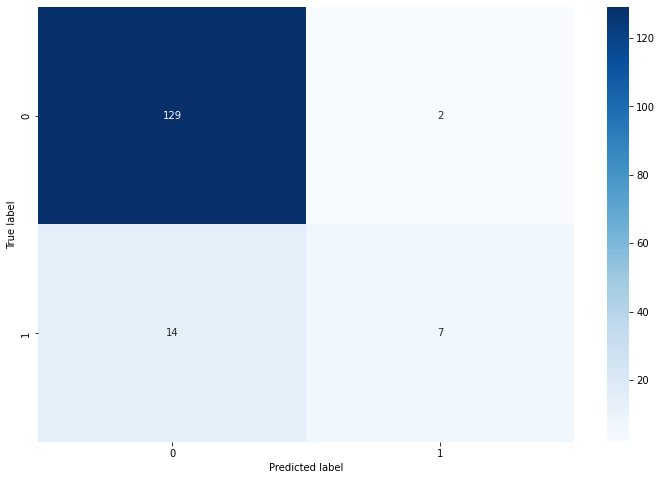

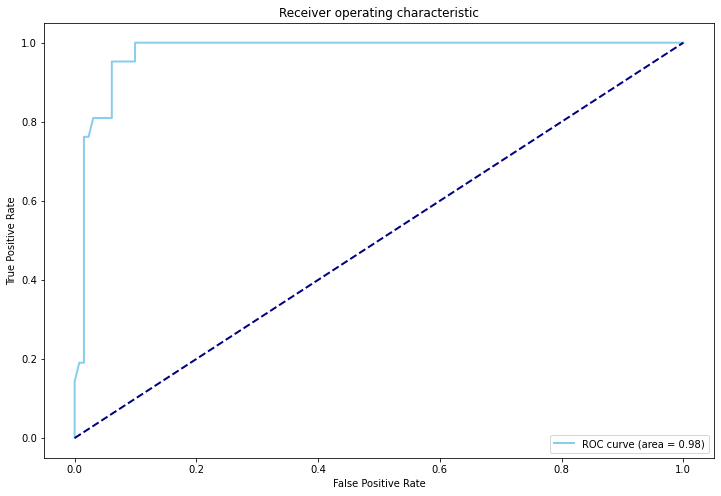

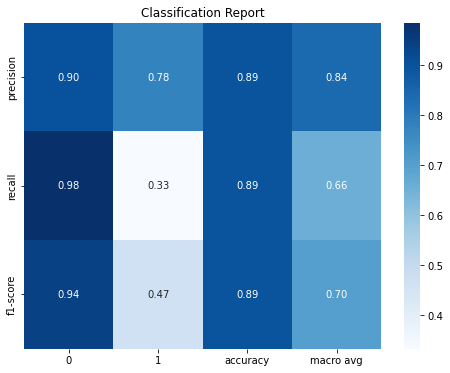

Accuracy: 0.89
Precision: 0.78
Recall: 0.33
F1 score: 0.47


XGBClassifier
Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}
[0.79091556 0.79180108 0.79180108 0.78217742 0.80717742 0.80384409
 0.80623814 0.82317204 0.815      0.75593741 0.76738253 0.79614528
 0.75183759 0.76765628 0.77916667 0.75183759 0.76563608 0.77916667]


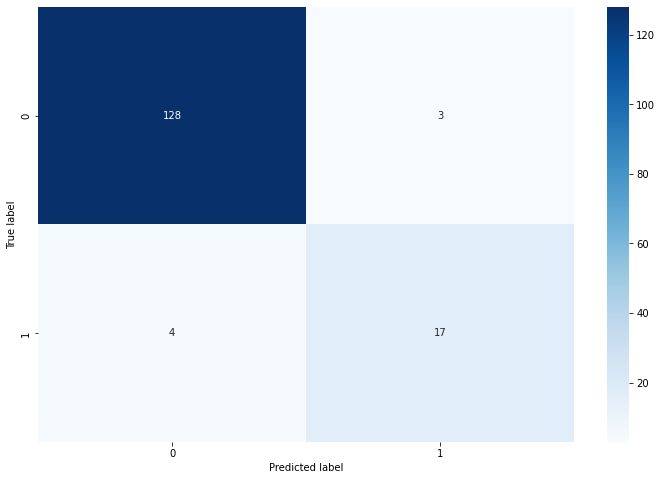

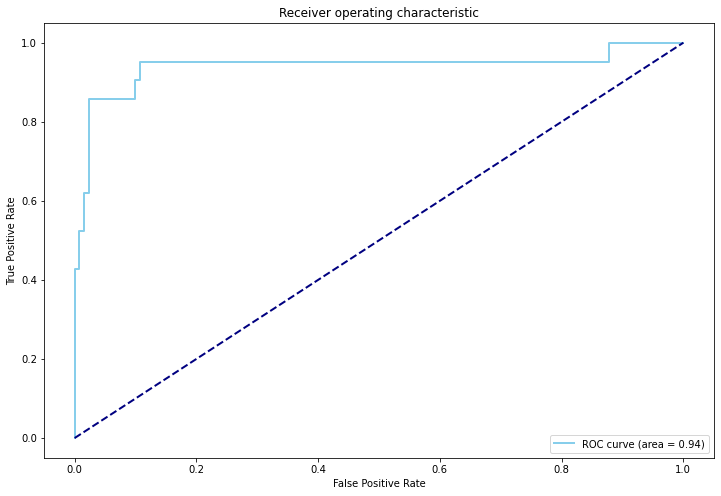

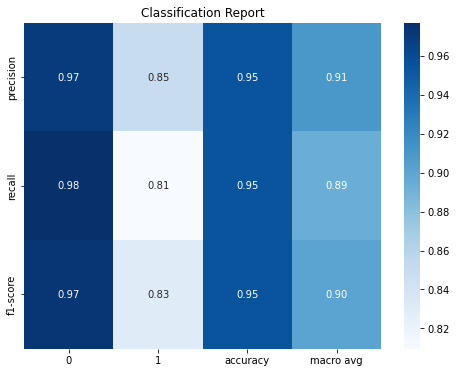

Accuracy: 0.95
Precision: 0.85
Recall: 0.81
F1 score: 0.83




In [21]:
for name, model in models.items():
    if name == 'Logistic Regression':
        param_grid = param_grid_lr
    elif name == 'Random Forest Classifier':
        param_grid = param_grid_rf
    else:
        param_grid = param_grid_xgb
        
    print(name)

    grid_search = GridSearchCV(model, param_grid, cv=5, scoring=scorer)
    grid_search.fit(X_train, y_train)

    print("Best hyperparameters:", grid_search.best_params_)
    
    print(grid_search.cv_results_['mean_test_score'])

    best_model = model.set_params(**grid_search.best_params_)
    best_model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = best_model.predict(X_test)
    
    # Generate confusion matrix for the test set
    conf_mat = confusion_matrix(y_test, y_pred)
    plt.figure(figsize = (12, 8))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap = 'Blues')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()
    
    # Generate ROC curve for the test set
    y_prob = best_model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize = (12, 8))
    plt.plot(fpr, tpr, color='skyblue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
    # Generate classification report
    report = classification_report(y_test, y_pred, output_dict=True)

    # Convert report to dataframe and transpose it
    df = pd.DataFrame(report).transpose()[['precision', 'recall', 'f1-score']]

    # Generate heatmap of the classification report
    plt.figure(figsize=(8, 6))
    sns.heatmap(df.iloc[:-1, :].T, cmap='Blues', annot=True, fmt='.2f')
    plt.title('Classification Report')
    plt.show()
    
    # Calculate the accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label=True)
    recall = recall_score(y_test, y_pred, pos_label=True)
    f1 = f1_score(y_test, y_pred, pos_label=True)
    
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 score: {f1:.2f}")
    print("\n")